In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import string
import unicodedata
from pathlib import Path
import collections
import itertools
import time
import math
import random

import numpy as np

from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

# Environment Setup

In [2]:
IN_COLAB = False
MOUNT_DRIVE = False

save_path = Path("save/")
try:
    from google.colab import drive
    IN_COLAB = True
    
    if MOUNT_DRIVE:
        drive_mount_path = "/content/drive"
        drive.mount(drive_mount_path)

        mount_proj_root = Path(drive_mount_path)/"MyDrive"/"PyTorchNameGen"
        mount_proj_root.mkdir(parents=True, exist_ok=True)

        if not save_path.is_dir():
            mounted_path = str(mount_proj_root/"save/")
            target_path = str(save_path)
            !ln -s "{mounted_path}" "{target_path}"
            print("Symlinked: ", target_path)
        else:
            print("Skipped symlinking: ", target_path)
    
    assert torch.cuda.is_available()
    
    if not MOUNT_DRIVE:
        raise
except:
    save_path.mkdir(parents=True, exist_ok=True)


In [3]:
if not Path("names").is_dir():
  !curl "https://download.pytorch.org/tutorial/data.zip" -o "data.zip"
  !unzip -j "data.zip" "data/names/*" -d "names"

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loading Data

In [5]:
all_chars = string.ascii_letters + " .,;'-"
print(all_chars)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'-


In [6]:
def sanitise_line(line):
    # https://stackoverflow.com/a/518232/5013267
    return ''.join(
        c for c in unicodedata.normalize('NFD', line)
        if unicodedata.category(c) != 'Mn'
        and c in all_chars
    )

In [7]:
name_data = {}
for path in Path("names").rglob("*.txt"):
    with open(path, "r", encoding="utf8") as f:
        names = []
        for line in f.read().strip().split("\n"):
            names.append(sanitise_line(line))
        name_data[path.stem] = names
    
    print(f"Loaded: {path}")

Loaded: names/Arabic.txt
Loaded: names/Chinese.txt
Loaded: names/Czech.txt
Loaded: names/Dutch.txt
Loaded: names/English.txt
Loaded: names/French.txt
Loaded: names/German.txt
Loaded: names/Greek.txt
Loaded: names/Irish.txt
Loaded: names/Italian.txt
Loaded: names/Japanese.txt
Loaded: names/Korean.txt
Loaded: names/Polish.txt
Loaded: names/Portuguese.txt
Loaded: names/Russian.txt
Loaded: names/Scottish.txt
Loaded: names/Spanish.txt
Loaded: names/Vietnamese.txt


# Data Preparation Stuff

In [8]:
class OneHotTranslator:
    def __init__(self, elements):
        self.elements = elements
        self.n_elements = len(self.elements)
        
    def index_to_vec(self, index):
        return F.one_hot(torch.tensor([index]), num_classes=self.n_elements)[0]
    
    def index_from_vec(self, vec):
        return vec.argmax()
    
    def elm_to_vec(self, elm):
        return self.index_to_vec(self.elements.index(elm))
    
    def elm_from_vec(self, vec):
        return self.elements[int(self.index_from_vec(vec))]
    
    def __len__(self):
        return self.n_elements
    
    def __getitem__(self, val):
        if isinstance(val, int):
            return self.index_to_vec(val)
        else:
            return self.elm_to_vec(val)

In [9]:
category_translator = OneHotTranslator(tuple(name_data.keys()))
print(category_translator.elements)
print("len:", len(category_translator))

('Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese')
len: 18


In [10]:
char_translator = OneHotTranslator(["<SOS>", "<EOS>"] + list(all_chars))
print(char_translator.elements)
print("len:", len(char_translator))

['<SOS>', '<EOS>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', ' ', '.', ',', ';', "'", '-']
len: 60


In [11]:
# Category sizes
{cat_name: len(cat) for cat_name, cat in name_data.items()}

{'Arabic': 2000,
 'Chinese': 268,
 'Czech': 519,
 'Dutch': 297,
 'English': 3668,
 'French': 277,
 'German': 724,
 'Greek': 203,
 'Irish': 232,
 'Italian': 709,
 'Japanese': 991,
 'Korean': 94,
 'Polish': 139,
 'Portuguese': 74,
 'Russian': 9408,
 'Scottish': 100,
 'Spanish': 298,
 'Vietnamese': 73}

In [12]:
# convenience functions
def build_name(name, fixed_length):
    """
    Build a list of one-hot encoded vectors representing the given name string
    """
    ret = [char_translator.elm_to_vec(char) for char in (["<SOS>"] + list(name) + ["<EOS>"])]
    
    while len(ret) < fixed_length:
        ret.append(char_translator.elm_to_vec("<EOS>"))
    
    return ret

def unbuild_name(t_chars):
    """
    Inverse of build_name
    """
    return "".join([char_translator.elm_from_vec(vec) for vec in t_chars])

def build_category(category):
    """
    Build a one-hot encoded vector representing the given category string
    """
    return category_translator.elm_to_vec(category)

def unbuild_category(vec):
    """
    Inverse of build_category
    """
    return category_translator.elm_from_vec(vec)

In [13]:
# simple Dataset class wrapper around the above variables
class NamesDataset(Dataset):
    def __init__(self, max_length):
        self.max_length = max_length
        self._data_pairs = [(cat, name) for cat in name_data for name in name_data[cat]]
    
    def __len__(self):
        return len(self._data_pairs)
    
    def __getitem__(self, index):
        cat, name = self._data_pairs[index]
        return build_category(cat), build_name(name, self.max_length)

# Neural

In [14]:
class SeqModel(nn.Module):
    def __init__(self, prime_size, input_size):
        super().__init__()
        self.prime_size = prime_size
        self.input_size = input_size
        self.hidden_size = 60
        
        self.lstm = nn.LSTMCell(self.input_size + self.prime_size, self.hidden_size)
        
        # NB: output size = input size
        self.fc = nn.Linear(self.hidden_size, self.input_size)
        
        self.dropout = nn.Dropout(0.1)
        self.lsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, t_prime, t_input, t_hidden, t_cell):
        # t_prime:     batches of vectors for the LSTM to be primed on
        #              shape: (N, prime_size)
        #
        # t_input:     shape: (N, input_size)
        #              t_input[0]: one-hot vector encoding of a character
        #
        # t_hidden:    shape: (N, hidden_size)
        #
        # t_cell:      shape: (N, hidden_size)
        
        # lstm_input:  t_prime and t_input concated together
        #              shape: (N, prime_size + input_size)
        lstm_input = torch.cat((t_prime, t_input), dim=1)
        t_hidden, t_cell = self.lstm(lstm_input.float(), (t_hidden, t_cell))
        
        # t_output:    shape: (N, input_size)
        #              NB: t_output's shape = t_input's shape
        t_output = self.fc(self.dropout(t_hidden))
        t_output = self.lsoftmax(t_output)
        
        return t_output, t_hidden, t_cell
    
    def init_hidden(self, batch_size=1):
        t_hidden = torch.zeros(batch_size, self.hidden_size)
        t_cell = torch.zeros(batch_size, self.hidden_size)
        
        return t_hidden, t_cell

In [15]:
model = SeqModel(len(category_translator), len(char_translator))
model.to(device)

SeqModel(
  (lstm): LSTMCell(78, 60)
  (fc): Linear(in_features=60, out_features=60, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (lsoftmax): LogSoftmax(dim=1)
)

In [16]:
# test_category_index = 0

# t_prime = category_translator[test_category_index].view(1, len(category_translator))
# print("t_prime shape:\t", t_prime.shape)

# t_input = char_translator["<SOS>"].view(1, len(char_translator))
# print("t_input shape:\t", t_input.shape)

# t_hidden, t_cell = model.init_hidden(1)
# print("t_hidden shape:\t", t_hidden.shape)
# print("t_cell shape:\t", t_cell.shape)

In [17]:
# t_output, t_hidden, t_cell = model.forward(t_prime, t_input, t_hidden, t_cell)
# print("t_output shape:\t", t_output.shape)
# print("t_hidden shape:\t", t_hidden.shape)
# print("t_cell shape:\t", t_cell.shape)

# Eval

In [18]:
def generate(max_length, category_name="German", N=3, ignore=True, temperature=1.0):
    with torch.no_grad():
        t_prime = category_translator[category_name].unsqueeze(0).repeat((N, 1)).to(device)
        t_char = char_translator["<SOS>"].unsqueeze(0).repeat((N, 1)).to(device)
        t_hidden, t_cell = map(lambda x: x.to(device), model.init_hidden(N))

        output_dict = collections.defaultdict(str)
        done_set = []
        for char_index in range(max_length):
            t_output, t_hidden, t_cell = model(t_prime, t_char, t_hidden, t_cell)
            
            sel_chars = np.zeros((N, len(char_translator)))
            for n in range(N):
                if ignore and n in done_set:
                    sel_chars[n] = char_translator.elm_to_vec("<EOS>")
                    continue
                    
                vec = t_output[n]
                sel_index = random.choices(range(len(vec)), weights=torch.exp(vec / temperature))[0]
                translated_char = char_translator.elements[sel_index]
        
                sel_chars[n] = np.eye(len(vec))[sel_index]
    
                if ignore and translated_char == "<EOS>":
                    done_set.append(n)
                    continue
                    
                output_dict[n] += translated_char
            t_char = torch.tensor(sel_chars).to(device)
        
        return [output_dict[n] for n in range(N)]

In [19]:
def generate_debug(max_length, gen_cats=None, temps=None):
    if gen_cats is None:
        gen_cats = category_translator.elements
        
    if temps is None:
        temps = [(3*(x+1) - 1)/10 for x in range(4)]
        
    gen_string = ""
    for gen_cat in gen_cats:
        gen_string += "{}:\n{}\n".format(gen_cat, "\n".join([
            "  t={}: {}".format(t, ", ".join(generate(max_length, gen_cat, temperature=t)))
            for t in temps
        ]))
    return gen_string

# Training

In [20]:
max_length = max([len(name) for name in itertools.chain(*name_data.values())]) + 2  # +2 for SOS and EOS
print(max_length)

22


In [21]:
sample_count = len(tuple(itertools.chain(*name_data.values())))
print(sample_count)

20074


In [30]:
# config
batch_size = 64
num_epochs = 30
# num_batches = math.ceil(sample_count/batch_size) * num_epochs
learning_rate = 0.0003
save_every = 50
gen_every = 50
plot_limit = None

In [23]:
train_dataloader = DataLoader(NamesDataset(max_length), batch_size=batch_size, shuffle=True, collate_fn=lambda x: x)

In [24]:
losses = collections.deque(maxlen=plot_limit)

In [25]:
criterion = nn.NLLLoss()
optimiser = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)

In [26]:
save_path = Path("save/")
should_save = True
model_name = "test"

In [27]:
model_path = None
for model_path in sorted(save_path.rglob(model_name + "*.pth")):
    print("Found: ", model_path)

if model_path is not None:
    model = torch.load(model_path, map_location=device)
    model.to(device)
    model.eval()
    print("Loaded: ", model_path)
else:
    print("No saved model!")

No saved model!


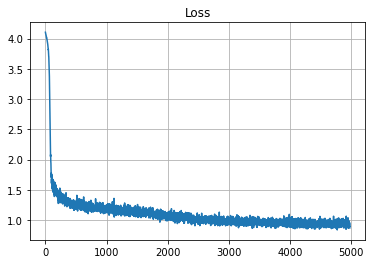

epoch: 5 batch_no: 313 loss: 0.870353
Russian:
  t=0.2: Bakanov, Sharov, Aranin
  t=0.5: Banilev, Malovegin, Bakanev
  t=0.8: Chalinin, Sleld, Rocheriv
  t=1.1: JanavShv, Vijagrazim, Tlyunov
German:
  t=0.2: Sharer, Maren, Manen
  t=0.5: Man, Taret, Ronen
  t=0.8: FAnin, Tultil, Kargda
  t=1.1: Btaateyf, Dweot, Qdiltrenin
Spanish:
  t=0.2: Arara, Arara, Salela
  t=0.5: Pani, Ralain, Aarera
  t=0.8: Ganady, Hautmie, Jalan
  t=1.1: Juzeee, Sramojrer, X reno
Chinese:
  t=0.2: Kor, Kan, Mor
  t=0.5: Barz, Man, Patn
  t=0.8: Arz, Tuso, Gacin
  t=1.1: Rokky, Vait, Mop



In [32]:
gen_string = ""
gen_cats = ["Russian", "German", "Spanish", "Chinese"]

for epoch_no in range(num_epochs):
    for batch_no, batch in enumerate(train_dataloader):
        t_prime = torch.stack([sample[0] for sample in batch]).to(device)
        t_hidden, t_cell = map(lambda x: x.to(device), model.init_hidden(t_prime.size(0)))

        model.zero_grad()
        loss = 0
        for char_index in range(max_length - 1):
            t_char = torch.stack([sample[1][char_index] for sample in batch]).to(device)
            t_output, t_hidden, t_cell = model(t_prime, t_char, t_hidden, t_cell)

            t_target = torch.stack([sample[1][char_index + 1].argmax() for sample in batch]).to(device)
            loss += criterion(t_output, t_target)

        loss.backward()
        optimiser.step()

        name_loss = loss.item() / (max_length - 1)
        losses.append(name_loss)

        plt.figure()
        plt.plot(losses, scalex=True)
        plt.title("Loss")
        plt.grid(True)
        plt.show()
        
        if batch_no % gen_every == 0:
            gen_string = generate_debug(max_length, gen_cats)

        print("epoch: {} batch_no: {} loss: {:.06f}\n{}".format(
            epoch_no, 
            batch_no, 
            name_loss,
            gen_string
        ))
        clear_output(wait=True)
        
        if should_save:
            if batch_no % save_every == 0:
                timestamp = int(time.time()/10000)
                torch.save(model, save_path / "{}_{}.pth".format(model_name, timestamp))
                torch.save(model.state_dict(), save_path / "{}_{}.pt".format(model_name, timestamp))           
        

# Post-Training Eval

In [33]:
print(generate_debug(max_length))

Arabic:
  t=0.2: Sari, Maras, Araha
  t=0.5: Sazo, Shalan, Namau
  t=0.8: Okunba, Capa, Gadin
  t=1.1: HWeoch, Nancy, Pderoa
Chinese:
  t=0.2: Man, Ara, Ban
  t=0.5: Kari, Balo, Jir
  t=0.8: Eose, chao, V'ee
  t=1.1: raga, Puzal, Hairf
Czech:
  t=0.2: Manin, Jarus, Arer
  t=0.5: Syakin, Sela, Hobotj
  t=0.8: Tatroy, Bela, Allali
  t=1.1: Praje, Womekim, Nundakd
Dutch:
  t=0.2: Barsov, Balen, Arin
  t=0.5: Jaskan, Bater, Valce
  t=0.8: Lern, Clal, Hoals
  t=1.1: oorrta, Wimelebcf, RenWea
English:
  t=0.2: Mars, Aron, Arrer
  t=0.5: Shargof, Palenco, Chalel
  t=0.8: Batnpon, vonkrstcen, Teed
  t=1.1: Yorhu, Wuzar, Lifheky
French:
  t=0.2: Malan, Barer, Marer
  t=0.5: Baliri, Seroer, Sarer
  t=0.8: Yaelare, PBanels, Ianin
  t=1.1: , sbaga, GAnwiy
German:
  t=0.2: Marler, Shant, Sarov
  t=0.5: Pan, Antin, Sheren
  t=0.8: Panlas, Ternon, Srnchen
  t=1.1: Tsrzar, Rraf, Elake
Greek:
  t=0.2: Baratarov, Araki, Bakaran
  t=0.5: Tadoni, Anreorna, Salano
  t=0.8: Etreriiho, Zgaeke, Shiel
  t=1.1: